# AICE (Associate) Technical Test
April 2020

Part 2. Exploratory Data Analysis

Submitted by: XU Yuting

## Section 1. Import Data

In [1]:
# import relevant libraries
import sys
import pandas as pd
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# connect to SQL server database
conn = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                      'Server=aice.database.windows.net;'
                      'Database=aice;'
                      'UID=aice_candidate;'
                      'PWD=@ic3_a3s0c1at3;')
sql_query = "\
select date, hr, weather, temperature, feels_like_temperature, relative_humidity, windspeed, psi, guest_scooter \
from rental_data \
where date between '2011-01-01' and '2012-12-31'\
"

# load the datset into Pandas dataframe, df
df = pd.io.sql.read_sql(sql_query,conn)

## Section 2. Examine the data columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18643 entries, 0 to 18642
Data columns (total 9 columns):
date                      18643 non-null object
hr                        18643 non-null int64
weather                   18643 non-null object
temperature               18643 non-null float64
feels_like_temperature    18643 non-null float64
relative_humidity         18643 non-null float64
windspeed                 18643 non-null float64
psi                       18643 non-null int64
guest_scooter             18643 non-null int64
dtypes: float64(4), int64(3), object(2)
memory usage: 1.3+ MB


In [4]:
df.describe()

,hr,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter
count,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000
mean,11.537145,88.433037,117.313608,62.733251,12.741082,25.142198,106.388940
std,6.924281,16.252200,20.364081,19.315897,8.217008,14.442978,147.151664
min,0.000000,48.100000,60.800000,0.000000,0.000000,0.000000,-2.000000
25%,6.000000,75.200000,100.400000,48.000000,7.000000,13.000000,12.000000
50%,12.000000,88.700000,118.400000,63.000000,13.000000,25.000000,50.000000
75%,18.000000,102.200000,134.600000,78.000000,17.000000,38.000000,144.000000
max,23.000000,131.000000,179.600000,100.000000,57.000000,50.000000,1099.000000


Bearing in mind that the purpose of the exercise is to predict the number of scooters, given the other variables, we have to pay attention to the 'guest_scooter' column, and understand that this is a numeric continous attribute.

In [5]:
df.head()

,date,hr,weather,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter
0,2012-07-02,23,clear,109.0,140.0,51.0,7.0,13,37
1,2011-12-22,10,cloudy,80.2,109.4,82.0,6.0,35,41
2,2011-02-25,11,clear,90.4,120.2,77.0,30.0,30,27
3,2012-03-10,1,clear,71.8,95.0,36.0,17.0,40,2
4,2011-06-19,5,cloudy,102.2,132.8,78.0,0.0,1,23


From the above we can see that:
- There are negative values in the column "guest_scooter" --> the negative values can't be true, so they will need to be removed
- Column 'weather' contains non-numeric values --> this will need to be scrutinized in detail and transformed to numeric values
- Column 'date' is not numeric either --> we can extract the numeric attributes out into year, month, date
- Column 'relative_humidity' and 'psi' contains value 0 --> This is quite unrealistic, so we can treat them as missing value too

We will take a closer look at the 'weather' column

In [6]:
df['weather'].value_counts()

clear              11627
cloudy              4613
light snow/rain     1455
CLEAR                318
lear                 233
CLOUDY               126
clar                  99
loudy                 74
LIGHT SNOW/RAIN       48
cludy                 32
liht snow/rain        15
heavy snow/rain        3
Name: weather, dtype: int64

Looks like 'weather' column is not so clean: there are typo errors and misspellings that will need to be cleaned up before they can be transformed to numeric values.

By examining the data columns above, we have concluded that there are some data cleaning/preprocessing tasks we will need to perform:
- Column 'weather': clean up the typos, and transform to numeric data
- Column 'guest_scooter': remove negative values
- Column 'relative_humidity','psi': value 0 should be treated as null values
- Column 'date': transform to numeric data e.g. year, month, date, day of week

With these tasks in mind, we can now start to preprocess the data

## Section 3. Data Cleaning & Preprocessing

#### Task 1: Column 'Weather' -- Clean up typos and transform categorical data to numeric data

In [7]:
df['weather']=df['weather'].str.upper()
df['weather'].value_counts()

CLEAR              11945
CLOUDY              4739
LIGHT SNOW/RAIN     1503
LEAR                 233
CLAR                  99
LOUDY                 74
CLUDY                 32
LIHT SNOW/RAIN        15
HEAVY SNOW/RAIN        3
Name: weather, dtype: int64

In [8]:
# now we correct some of the spellings
df.loc[df['weather']=='LEAR','weather']='CLEAR'
df.loc[df['weather']=='CLAR','weather']='CLEAR'
df.loc[df['weather']=='CLUDY','weather']='CLOUDY'
df.loc[df['weather']=='LOUDY','weather']='CLOUDY'
df.loc[df['weather']=='LIHT SNOW/RAIN','weather']='LIGHT SNOW/RAIN'

df['weather'].value_counts()

CLEAR              12277
CLOUDY              4845
LIGHT SNOW/RAIN     1518
HEAVY SNOW/RAIN        3
Name: weather, dtype: int64

In [9]:
# map weather to integer
map_weather = {'CLEAR': 1, 'CLOUDY': 2,'LIGHT SNOW/RAIN':3,'HEAVY SNOW/RAIN':4}
df.replace({'weather': map_weather})


,date,hr,weather,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter
0,2012-07-02,23,1,109.0,140.0,51.0,7.0,13,37
1,2011-12-22,10,2,80.2,109.4,82.0,6.0,35,41
2,2011-02-25,11,1,90.4,120.2,77.0,30.0,30,27
3,2012-03-10,1,1,71.8,95.0,36.0,17.0,40,2
4,2011-06-19,5,2,102.2,132.8,78.0,0.0,1,23
...,...,...,...,...,...,...,...,...,...
18638,2011-06-11,19,1,105.6,138.2,65.0,13.0,5,290
18639,2011-11-21,14,2,87.0,116.6,82.0,13.0,43,40
18640,2012-04-17,9,1,97.2,134.6,38.0,33.0,10,211
18641,2012-10-25,21,2,90.4,120.2,88.0,9.0,28,73


We are set!

#### Task 2: Column 'guest_scooter' -- remove negative values

In [10]:
df['guest_scooter'].replace([-2,-1],np.nan,inplace=True)
df['guest_scooter'].describe()

count    17991.000000
mean       110.298371
std        148.328495
min          0.000000
25%         14.000000
50%         53.000000
75%        149.000000
max       1099.000000
Name: guest_scooter, dtype: float64

Notice that the count has reduced. This means that some of the negative values have been converted to NULL

#### Task 3: Column 'relative_humidity','psi' -  value 0 should be treated as null values

In [11]:
df['relative_humidity'].replace(0,np.nan,inplace=True)
df['relative_humidity'].describe()

count    18618.000000
mean        62.817488
std         19.191483
min          8.000000
25%         48.000000
50%         63.000000
75%         78.000000
max        100.000000
Name: relative_humidity, dtype: float64

In [12]:
df['psi'].replace(0,np.nan,inplace=True)
df['psi'].describe()

count    18443.000000
mean        25.414846
std         14.280482
min          1.000000
25%         13.000000
50%         26.000000
75%         38.000000
max         50.000000
Name: psi, dtype: float64

#### Task 4: Column 'date' - transform to numeric data e.g. year, month, date, day of week

In [13]:
# first we convert the date column to date object
dt=df['date']
df['date']=pd.to_datetime(dt)

In [14]:
type(df['date'].values[0])

numpy.datetime64

Now we need to create new columns and extract the year, month, date, and weekday attributes

In [15]:
df['year']=df['date'].dt.year
df['month']=df['date'].dt.month
df['day']=df['date'].dt.day
df['weekday']=df['date'].apply(lambda x: x.weekday())
df.head()

,date,hr,weather,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter,year,month,day,weekday
0,2012-07-02,23,CLEAR,109.0,140.0,51.0,7.0,13.0,37.0,2012,7,2,0
1,2011-12-22,10,CLOUDY,80.2,109.4,82.0,6.0,35.0,41.0,2011,12,22,3
2,2011-02-25,11,CLEAR,90.4,120.2,77.0,30.0,30.0,27.0,2011,2,25,4
3,2012-03-10,1,CLEAR,71.8,95.0,36.0,17.0,40.0,2.0,2012,3,10,5
4,2011-06-19,5,CLOUDY,102.2,132.8,78.0,0.0,1.0,23.0,2011,6,19,6


In the 'weekday' column, we notice that the number ranges from 0 to 6. We are going to add 1 to the values.

In [16]:
df['weekday']=df['weekday']+1
df.head()

,date,hr,weather,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter,year,month,day,weekday
0,2012-07-02,23,CLEAR,109.0,140.0,51.0,7.0,13.0,37.0,2012,7,2,1
1,2011-12-22,10,CLOUDY,80.2,109.4,82.0,6.0,35.0,41.0,2011,12,22,4
2,2011-02-25,11,CLEAR,90.4,120.2,77.0,30.0,30.0,27.0,2011,2,25,5
3,2012-03-10,1,CLEAR,71.8,95.0,36.0,17.0,40.0,2.0,2012,3,10,6
4,2011-06-19,5,CLOUDY,102.2,132.8,78.0,0.0,1.0,23.0,2011,6,19,7


We are done with preprocessing! These steps will also be performed in the data cleaning/preprocessing phase of the MLP.
Now on to exploring some basic relationships between the attributes.

## Section 4. Data Visualization


Bearing in mind that the final purpose of the exercise is to predict the number of active e-scooter riders. Over here, we should try to aim to look for relationships between the other attributes with the target attribute (guest_scooters).

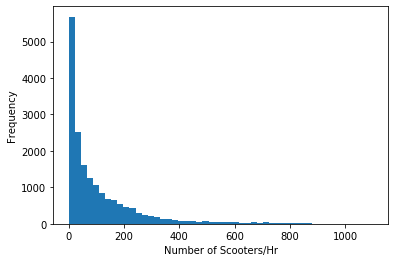

In [17]:
# first we look at the distribution of ridership/hour
plt.hist(df['guest_scooter'].dropna(),bins=50)
plt.xlabel('Number of Scooters/Hr')
plt.ylabel('Frequency')
plt.show()

We can see that the number of scooters/hour does not follow a normal distribution. It is heavily right-tailed.

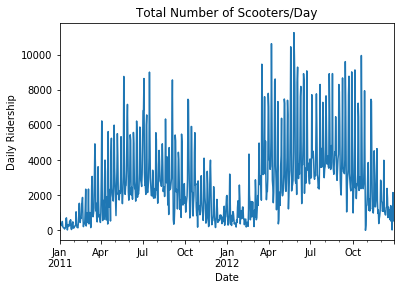

In [18]:
# now we want to see if there's a longitudinal trend on daily total scooter number
group_by_day=df.groupby('date').guest_scooter.sum()
group_by_day.plot()
plt.xlabel('Date')
plt.ylabel('Daily Ridership')
plt.title("Total Number of Scooters/Day")
plt.show()

What we can observe from above is a clear seasonal trend: numbers spike up in horter months (May - August), and drop in colder months (Oct - Apr). There are also high variations across days

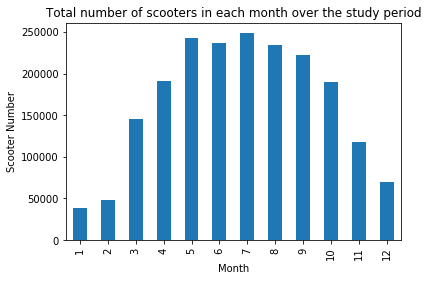

In [19]:
# we can see the seasonal trends more clearly if we plot the total number of riders per month
group_by_month=df.groupby('month').guest_scooter.sum()
group_by_month.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Scooter Number')
plt.title("Total number of scooters in each month over the study period")
plt.show()

Text(0.5, 1, 'Mean hourly scooters per hour')

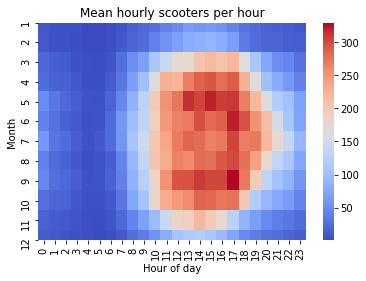

In [20]:

sns.heatmap(pd.crosstab(df['month'],df['hr'],values=df['guest_scooter'],aggfunc='mean'),cmap='coolwarm')
plt.ylabel("Month")
plt.xlabel("Hour of day")
plt.title("Mean hourly scooters per hour")

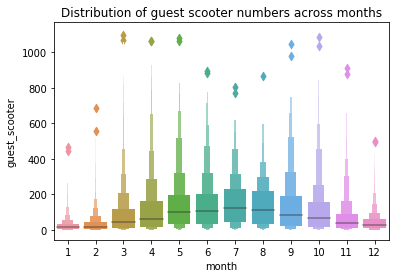

In [21]:
sns.boxenplot(data=df, x="month",y="guest_scooter")
plt.title("Distribution of guest scooter numbers across months")
plt.show()

The number of scooters shows clear monthly and daily variations.
What actually makes a difference in the different months and hours is the climatic conditions, this means:
- temperature
- feels_like_temperature
- relative_humidity
- psi
- windspeed
- weather

All these conditions will have some influence in the result. What is interesting from the boxenplot above is also that there are two peaks/maximum hourly ridership in a year, one in March-May, the other in September - November. Now we know that Summer is usually the hottest time of a year -- we are talking about temperature here. If so, it looks like other factors e.g. thermal comfort, wind, and humidity might have an effect to scooters too. We will look at this in detail.

Before we drill in on the climatic factors, there is another temporal scale we have not explored: variations in a day.

In [22]:
# resample by hour of day
mean_rider_by_hr = df.groupby('hr')['guest_scooter'].mean().sort_index()
mean_temp_by_hr = df.groupby('hr')['temperature'].mean().sort_index()
mean_fltemp_by_hr=df.groupby('hr')['feels_like_temperature'].mean().sort_index()
mean_psi_by_hr=df.groupby('hr')['psi'].mean().sort_index()
mean_rh_by_hr=df.groupby('hr')['relative_humidity'].mean().sort_index()
mean_windspeed_by_hr=df.groupby('hr')['windspeed'].mean().sort_index()

In [23]:
# merge into a new dataframe
frame={'rider':mean_rider_by_hr,
      'temp':mean_temp_by_hr,
      'fltemp':mean_fltemp_by_hr,
      'psi':mean_psi_by_hr,
      'rh':mean_rh_by_hr,
      'windspeed':mean_windspeed_by_hr}
df_by_hr=pd.DataFrame(frame)
df_by_hr.head()


,rider,temp,fltemp,psi,rh,windspeed
hr,,,,,,
0,32.221039,86.366963,114.934943,25.952625,69.620865,10.790343
1,20.975510,85.522080,113.767137,24.669281,70.439589,10.681643
2,16.647399,85.097532,113.268831,25.319737,72.029909,10.340260
3,10.001570,84.589481,112.748336,25.862534,73.187750,10.061252
4,4.949917,84.132389,112.127935,26.070748,74.124157,10.480432


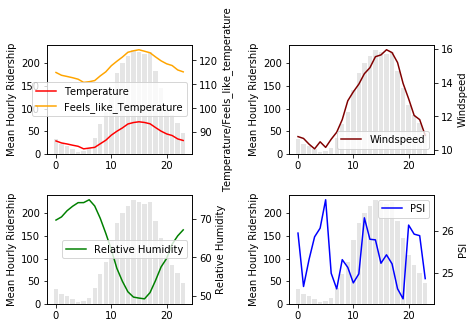

In [26]:
# plot the variables to 4 subplots
fig,ax=plt.subplots(2,2)
fig.tight_layout(pad=0.4, w_pad=6, h_pad=2.0)

ax[0,0].bar(df_by_hr.index,df_by_hr['rider'],alpha=0.2,color='grey')
ax2=ax[0,0].twinx()
ax2.plot(df_by_hr.index,df_by_hr['temp'],color='r')
ax2.plot(df_by_hr.index,df_by_hr['fltemp'],color='orange')
ax[0,0].set_ylabel('Mean Hourly Ridership')
ax2.set_ylabel("Temperature/Feels_like_temperature")
plt.legend(['Temperature','Feels_like_Temperature'])

ax[0,1].bar(df_by_hr.index,df_by_hr['rider'],alpha=0.2,color='grey')
ax3=ax[0,1].twinx()
ax3.plot(df_by_hr.index,df_by_hr['windspeed'],color='maroon')
ax[0,1].set_ylabel('Mean Hourly Ridership')
ax3.set_ylabel("Windspeed")
plt.legend(['Windspeed'])

ax[1,0].bar(df_by_hr.index,df_by_hr['rider'],alpha=0.2,color='grey')
ax4=ax[1,0].twinx()
ax4.plot(df_by_hr.index,df_by_hr['rh'],color='green')
ax[1,0].set_ylabel('Mean Hourly Ridership')
ax4.set_ylabel('Relative Humidity')
plt.legend(['Relative Humidity'])

ax[1,1].bar(df_by_hr.index,df_by_hr['rider'],alpha=0.2,color='grey')
ax5=ax[1,1].twinx()
ax5.plot(df_by_hr.index,df_by_hr['psi'],color='blue')
ax[1,1].set_ylabel('Mean Hourly Ridership')
ax5.set_ylabel("PSI")
plt.legend(['PSI'])

plt.show()

We can observe from the above that the shape of the hourly scooters follow windspeed most strongly, to a lesser extent, the temperature and feels_like_temperature. PSI does no seem a strong explanatory variable while relative humidity has a negative relationship.

The exact influence of each factor may vary in different seasons.

We want to create the same graphs as above, but this time, split them into seasons. This time we will narrow down to only temperature and windspeed.
We will split the months into:
- spring: Mar, Apr, May
- summer: June, July, Aug
- fall: Sept, Oct, Nov
- winter: Dec, Jan, Feb

In [27]:
# create a new column 'Season' and do the mapping by months
df['season']=df['month']


In [28]:
# map month into season
df['season'].replace([3,4,5],'Spring',inplace=True)
df['season'].replace([6,7,8],'Summer',inplace=True)
df['season'].replace([9,10,11],'Fall',inplace=True)
df['season'].replace([12,1,2],'Winter',inplace=True)

In [29]:
df.head()

,date,hr,weather,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter,year,month,day,weekday,season
0,2012-07-02,23,CLEAR,109.0,140.0,51.0,7.0,13.0,37.0,2012,7,2,1,Summer
1,2011-12-22,10,CLOUDY,80.2,109.4,82.0,6.0,35.0,41.0,2011,12,22,4,Winter
2,2011-02-25,11,CLEAR,90.4,120.2,77.0,30.0,30.0,27.0,2011,2,25,5,Winter
3,2012-03-10,1,CLEAR,71.8,95.0,36.0,17.0,40.0,2.0,2012,3,10,6,Spring
4,2011-06-19,5,CLOUDY,102.2,132.8,78.0,0.0,1.0,23.0,2011,6,19,7,Summer


In [30]:
df['season'].replace('Spring',1,inplace=True)
df['season'].replace('Summer',2,inplace=True)
df['season'].replace('Fall',3,inplace=True)
df['season'].replace('Winter',4,inplace=True)
df.head()

,date,hr,weather,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter,year,month,day,weekday,season
0,2012-07-02,23,CLEAR,109.0,140.0,51.0,7.0,13.0,37.0,2012,7,2,1,2
1,2011-12-22,10,CLOUDY,80.2,109.4,82.0,6.0,35.0,41.0,2011,12,22,4,4
2,2011-02-25,11,CLEAR,90.4,120.2,77.0,30.0,30.0,27.0,2011,2,25,5,4
3,2012-03-10,1,CLEAR,71.8,95.0,36.0,17.0,40.0,2.0,2012,3,10,6,1
4,2011-06-19,5,CLOUDY,102.2,132.8,78.0,0.0,1.0,23.0,2011,6,19,7,2


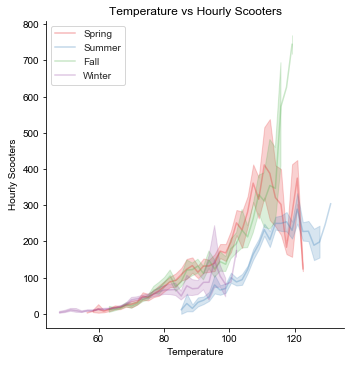

In [31]:
# how does temperature affect the ridership in different seasons?
sns.relplot(x="temperature",y="guest_scooter",data=df,kind="line",hue="season",alpha=0.3,palette='Set1',legend=False)
sns.set_style("white")
plt.title("Temperature vs Hourly Scooters")
plt.xlabel("Temperature")
plt.ylabel("Hourly Scooters")
plt.legend(['Spring','Summer','Fall','Winter'])
plt.show()

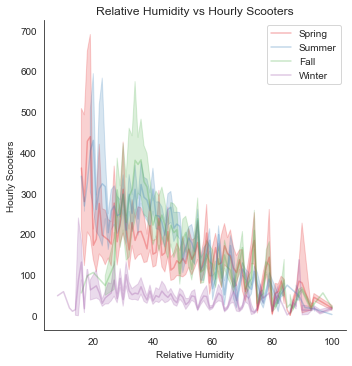

In [32]:
# how does temperature affect the ridership in different seasons?
sns.relplot(x="relative_humidity",y="guest_scooter",data=df,kind="line",hue="season",alpha=0.3,palette='Set1',legend=False)
sns.set_style("white")
plt.title("Relative Humidity vs Hourly Scooters")
plt.xlabel("Relative Humidity")
plt.ylabel("Hourly Scooters")
plt.legend(['Spring','Summer','Fall','Winter'])
plt.show()

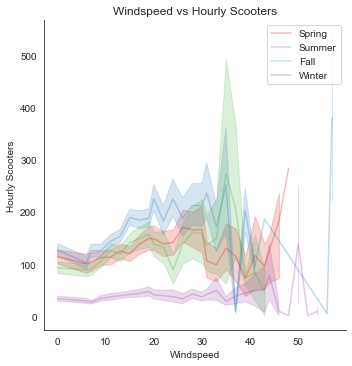

In [33]:
# how does temperature affect the ridership in different seasons?
sns.relplot(x="windspeed",y="guest_scooter",data=df,kind="line",hue="season",alpha=0.3,palette='Set1',legend=False)
sns.set_style("white")
plt.title("Windspeed vs Hourly Scooters")
plt.xlabel("Windspeed")
plt.ylabel("Hourly Scooters")
plt.legend(['Spring','Summer','Fall','Winter'])
plt.show()

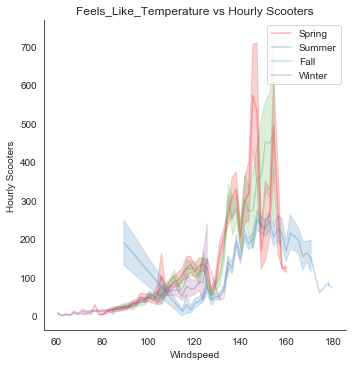

In [34]:
# how does temperature affect the ridership in different seasons?
sns.relplot(x="feels_like_temperature",y="guest_scooter",data=df,kind="line",hue="season",alpha=0.3,palette='Set1',legend=False)
sns.set_style("white")
plt.title("Feels_Like_Temperature vs Hourly Scooters")
plt.xlabel("Windspeed")
plt.ylabel("Hourly Scooters")
plt.legend(['Spring','Summer','Fall','Winter'])
plt.show()

## Section 5. Conclusion

After thie exercise, we have come to the understanding of:
- the basic structure of this dataset, e.g. the target feature, 'guest_scooter', is a continuous numeric feature. This will help us choose hte suitable models in our Machine Learning Pipeline later.
- the preprocessing steps required on this dataset
- Several attributes that might have strong influence on the number of scooters, especially hour of day, month/season, temperature, relative_humidity, and windspeed

All these will come in handy when we build the Machine Learning Pipeline for predicting the scooter numbers.